In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')

<ipython-input-1-e435f1e9ca2b>:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png','pdf')


In [38]:
TrainMat = np.load('TrainDigits.npy')
TrainLabel = np.load('TrainLabels.npy').flatten()
TestMat = np.load('TestDigits.npy')
TestLabel = np.load('TestLabels.npy').flatten()

In [4]:
print("TrainMat shape:", TrainMat.shape)
print("TrainLabel shape:", TrainLabel.shape)
print("TestMat shape:", TestMat.shape)
print("TestLabel shape:", TestLabel.shape)

TrainMat shape: (784, 240000)
TrainLabel shape: (240000,)
TestMat shape: (784, 40000)
TestLabel shape: (40000,)


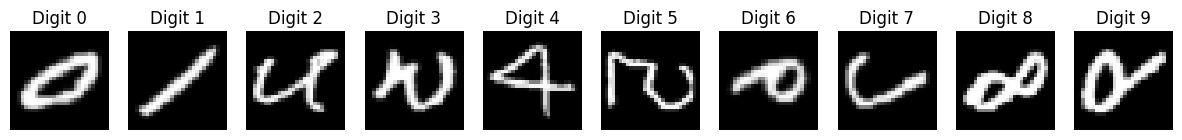

In [5]:
fig, axs = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    digit_index = np.where(TrainLabel == i)[0][0]
    digit = TrainMat[:, digit_index].reshape(28, 28)
    axs[i].imshow(digit, cmap='gray')
    axs[i].set_title(f"Digit {i}")
    axs[i].axis('off')
plt.show()

In [60]:
def sort_data_by_label(data, labels, digit):
    indices = np.where(labels == digit)[0]
    return data[:, indices]

In [7]:
digit_3_train = sort_data_by_label(TrainMat, TrainLabel, 3)
print("Sorted data for digit 3 shape:", digit_3_train.shape)

Sorted data for digit 3 shape: (784, 24000)


In [61]:
def plot_singular_images(U_matrix, digit):
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(U_matrix[:, i].reshape(28, 28), cmap='gray')
        plt.title(f'Singular Image {i+1}')
        plt.axis('off')
    plt.suptitle(f'First Three Singular Images for Digit {digit}')
    plt.show()

In [72]:
def compute_Uk_matrices(train_data, num_basis_functions):
    Uk_matrices = {}
    for digit in range(10):
        digit_train_data = sort_data_by_label(train_data, TrainLabel, digit)
        digit_train_data_subset = digit_train_data[:, :num_basis_functions]
        digit_train_data_subset = digit_train_data_subset.astype(np.float32)  # Convert to single precision floats

        # Compute SVD
        U, _, _ = np.linalg.svd(digit_train_data_subset)

        # Store only the first k columns of U
        Uk_matrices[digit] = U[:, :num_basis_functions]
    return Uk_matrices

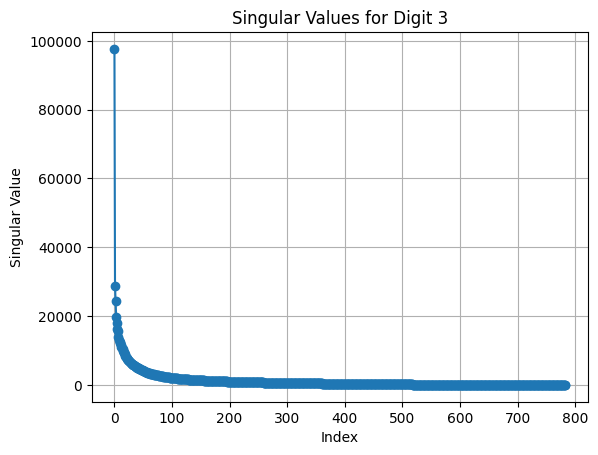

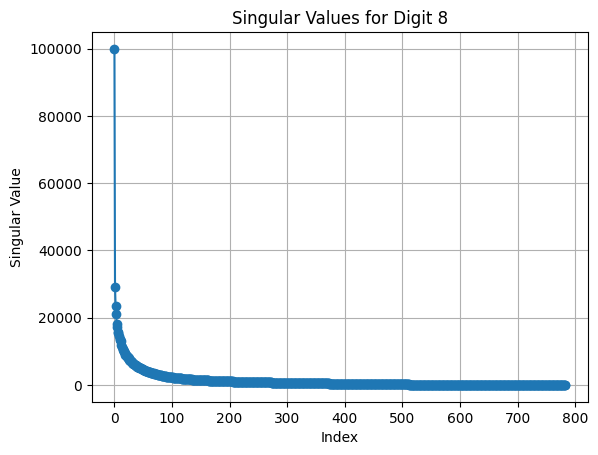

In [63]:
def compute_svd_and_plot_singular_values(train_data, digit, num_samples):
    digit_train_data = sort_data_by_label(train_data, TrainLabel, digit)
    digit_train_data_subset = digit_train_data[:, :num_samples].astype(np.float32)
    _, S, _ = np.linalg.svd(digit_train_data_subset)
    plt.plot(S, marker='o')
    plt.title(f'Singular Values for Digit {digit}')
    plt.xlabel('Index')
    plt.ylabel('Singular Value')
    plt.grid(True)
    plt.show()

compute_svd_and_plot_singular_values(TrainMat, digit=3, num_samples=2000)
compute_svd_and_plot_singular_values(TrainMat, digit=8, num_samples=2000)

In [11]:
Uk_matrices = compute_Uk_matrices(TrainMat, num_basis_functions=2000)

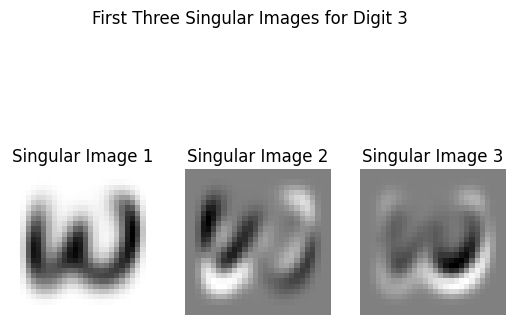

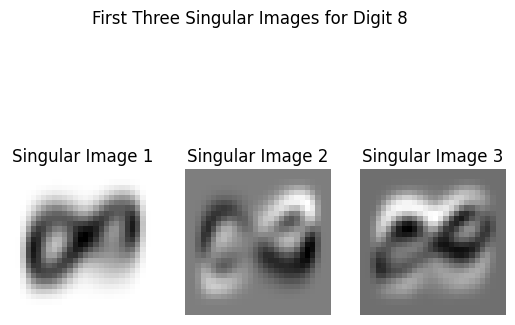

In [12]:
# Plot first three singular images for digits 3 and 8
plot_singular_images(Uk_matrices[3], digit=3)
plot_singular_images(Uk_matrices[8], digit=8)

In [13]:
Uk_matrices = compute_Uk_matrices(TrainMat, num_basis_functions=15)

In [64]:
def compute_residuals(Uk_matrices, test_data):
    residuals = np.zeros((10, test_data.shape[1]))
    for digit in range(10):
        Uk = Uk_matrices[digit]
        I_minus_Uk_UkT = np.identity(Uk.shape[0]) - Uk @ Uk.T
        for i in range(test_data.shape[1]):
            d = test_data[:, i]
            residual = np.linalg.norm(I_minus_Uk_UkT @ d)
            residuals[digit, i] = residual
    return residuals

In [15]:
test_residuals = compute_residuals(Uk_matrices, TestMat)

In [65]:
def classify_digits(residuals):
    return np.argmin(residuals, axis=0)

In [17]:
predicted_labels = classify_digits(test_residuals)
print("Predicted labels shape:", predicted_labels.shape)

Predicted labels shape: (40000,)


In [18]:
correct_classifications = np.sum(predicted_labels == TestLabel)
total_digits = TestLabel.shape[0]
percentage_correct = (correct_classifications / total_digits) * 100
print("Percentage of correct classifications:", percentage_correct)

Percentage of correct classifications: 84.5925


In [19]:
print("Predicted labels:", predicted_labels[:10])
print("True labels:", TestLabel[:10])

Predicted labels: [0 9 7 9 2 2 3 1 0 0]
True labels: [0 9 7 9 2 2 3 1 0 0]


In [20]:
min_residuals = np.min(test_residuals, axis=0)
print("Minimum residuals:", min_residuals)

Minimum residuals: [1334.73704116 1065.97458283 1054.49093216 ... 1095.44269063 1166.43291979
 1438.94580699]


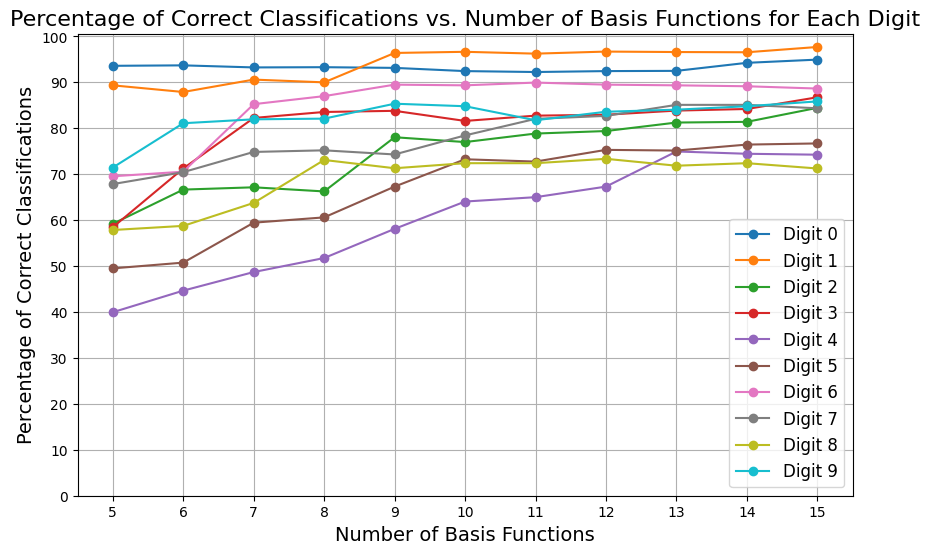

In [76]:
num_basis_functions_range = range(5, 16)
digit_success_percentage = {}

for digit in range(10):
    success_percentages = []
    digit_test_data = sort_data_by_label(TestMat, TestLabel, digit)
    digit_test_data = digit_test_data[:, :2000]
    digit_test_label = np.full((digit_test_data.shape[1],), digit)
    for num_basis_functions in num_basis_functions_range:
        Uk_matrices = compute_Uk_matrices(TrainMat, num_basis_functions=num_basis_functions)
        test_residuals = compute_residuals(Uk_matrices, digit_test_data)
        classified_digits = classify_digits(test_residuals)
        correct_classification = np.sum(classified_digits == digit_test_label)
        success_percentage = correct_classification / len(digit_test_label) * 100
        success_percentages.append(success_percentage)
    digit_success_percentage[digit] = success_percentages

# Plotting
plt.figure(figsize=(10, 6))
for digit in range(10):
    plt.plot(num_basis_functions_range, digit_success_percentage[digit], marker='o', label=f'Digit {digit}')
plt.title('Percentage of Correct Classifications vs. Number of Basis Functions for Each Digit', fontsize=16)
plt.xlabel('Number of Basis Functions', fontsize=14)
plt.ylabel('Percentage of Correct Classifications', fontsize=14)
plt.grid(True)
plt.xticks(num_basis_functions_range)
plt.yticks(range(0, 101, 10))
plt.legend(loc='lower right', fontsize=12)
plt.show()